In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn_extra.cluster import KMedoids

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird, attribute2idx

# Select independent concepts via k-medoids

In [2]:
class_attributes = get_class_attributes()
maj_concepts = class_attributes.loc[:, ((class_attributes >= 50).sum(0) >= 10)] >= 50 # CBM paper report 112 concepts
print(maj_concepts.shape) # CBM paper (200, 112)
maj_concepts.astype(int)

(200, 108)


,has_bill_shape::dagger,has_bill_shape::hooked_seabird,has_bill_shape::all-purpose,has_bill_shape::cone,has_wing_color::brown,has_wing_color::grey,has_wing_color::yellow,has_wing_color::black,has_wing_color::white,has_wing_color::buff,...,has_bill_color::black,has_crown_color::blue,has_crown_color::brown,has_crown_color::grey,has_crown_color::yellow,has_crown_color::black,has_crown_color::white,has_wing_pattern::solid,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
196,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
197,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


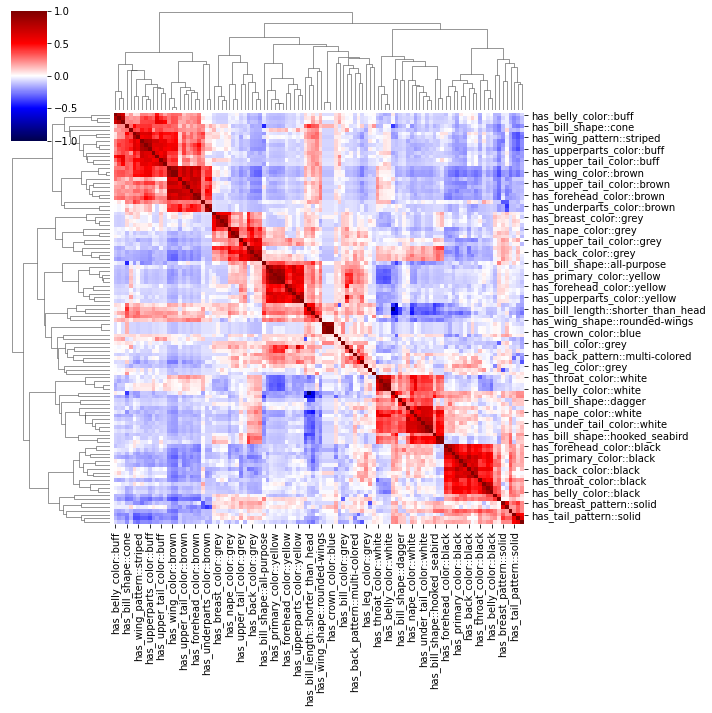

In [3]:
sns.clustermap(maj_concepts.corr(), cmap='seismic', vmax=1, vmin=-1)

In [12]:
lowest_error_ind_maj, lowest_error = None, np.inf
for i in tqdm.trange(30):
    kmedoids = KMedoids(n_clusters=10, metric='correlation', init='k-medoids++').fit(maj_concepts.T)
    ind_maj_concepts = maj_concepts.iloc[:, kmedoids.medoid_indices_]
    abs_sum = np.array(np.abs(ind_maj_concepts.corr())).sum()
    if abs_sum < lowest_error:
        lowest_error = abs_sum
        lowest_error_ind_maj = ind_maj_concepts

ind_maj_concepts = lowest_error_ind_maj
ind_maj_concepts

100%|██████████| 30/30 [00:00<00:00, 121.70it/s]


,has_upperparts_color::brown,has_primary_color::black,has_shape::perching-like,has_forehead_color::blue,has_belly_color::white,has_back_color::grey,has_size::very_small_(3_-_5_in),has_primary_color::yellow,has_back_color::white,has_back_pattern::solid
0,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,True
3,False,True,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
195,True,False,True,False,False,False,False,False,False,False
196,True,False,True,False,True,False,False,False,False,False
197,True,False,True,False,True,False,True,False,False,False
198,True,False,True,False,False,False,False,False,False,False


21.296034108133718


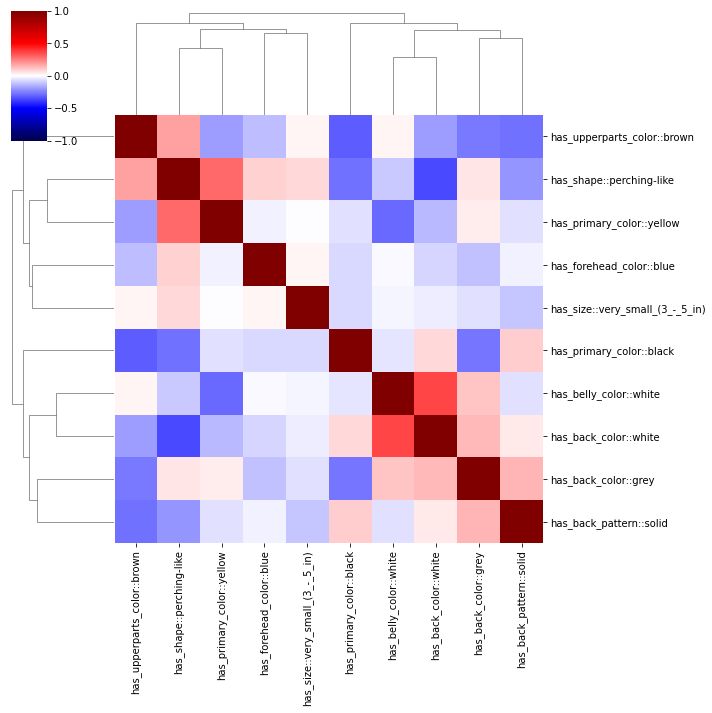

In [13]:
sns.clustermap(ind_maj_concepts.corr(), cmap='seismic', vmax=1, vmin=-1)
print(np.array(np.abs(ind_maj_concepts.corr())).sum())

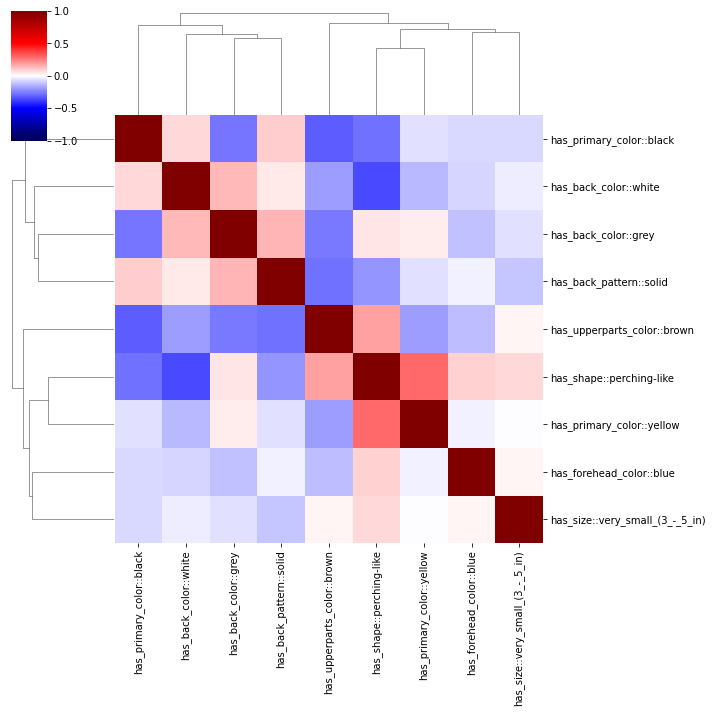

In [15]:
ind_list = list(ind_maj_concepts.columns)
ind_list.remove('has_belly_color::white')
ind_maj_concepts = ind_maj_concepts.loc[:, ind_list]
sns.clustermap(ind_maj_concepts.corr(), cmap='seismic', vmax=1, vmin=-1)

In [16]:
list(ind_maj_concepts.columns)

['has_upperparts_color::brown',
 'has_primary_color::black',
 'has_shape::perching-like',
 'has_forehead_color::blue',
 'has_back_color::grey',
 'has_size::very_small_(3_-_5_in)',
 'has_primary_color::yellow',
 'has_back_color::white',
 'has_back_pattern::solid']

In [17]:
get_class_attributes().loc[:, list(ind_maj_concepts.columns)]

,has_upperparts_color::brown,has_primary_color::black,has_shape::perching-like,has_forehead_color::blue,has_back_color::grey,has_size::very_small_(3_-_5_in),has_primary_color::yellow,has_back_color::white,has_back_pattern::solid
0,48.648649,26.845638,5.223881,1.449275,21.153846,2.307692,0.000000,1.923077,58.585859
1,41.666667,43.065693,1.587302,0.000000,11.111111,0.000000,0.000000,24.444444,68.888889
2,19.811321,30.201342,0.000000,0.000000,47.272727,4.838710,0.000000,21.818182,69.444444
3,6.153846,96.621622,31.538462,6.293706,2.521008,12.213740,0.000000,0.840336,87.288136
4,11.111111,76.146789,3.092784,0.000000,23.376623,0.000000,0.000000,3.896104,92.105263
...,...,...,...,...,...,...,...,...,...
195,92.957746,1.840491,84.313725,0.000000,13.846154,44.680851,0.000000,6.923077,48.461538
196,71.328671,17.964072,91.139241,0.000000,13.114754,43.065693,0.000000,27.049180,34.453782
197,60.625000,7.228916,82.517483,0.000000,41.481481,50.000000,1.204819,21.481481,26.515152
198,90.000000,2.515723,86.986301,0.000000,9.629630,46.923077,0.000000,5.925926,44.531250
